# 1. 사전 세팅

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum -qq
!sudo fc-cache -f
!rm -rf ~/.cache/matplotlib

%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링"

# !gdown --folder "data_link" --remaining-ok

/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링


In [3]:
!pwd

/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링


# 2. 문제 정의


---

    A 의류 회사에서 생산량을 조절하기 위해 판매량을 예측하려고 한다.
    의류 종류에 따라 계절성을 타기 때문에, 이런 특징을 고려할 수 있는 모델링이 필요하다.



## 2.1. 도메인 지식

---

▸ 티셔츠 제조의 Lead Time(주문부터 납품까지 걸리는 전체 시간)

    티셔츠 발주를 넣어 생산하는 데 통상 2~3주가 걸린다.
    그러나, 보통 베트남이나 중국 등의 해외에서의 생산을 주로 하기 때문에 유통 시간까지 고려해서 계산해야 한다.
    배에 싣거나, 검사하거나, 이동하는 시간까지 고려하게 되면 총 8주 정도가 걸린다고 예상한다.

▸ 재고 비용

    재고를 가지고 있을 때 발생하는 비용으로, 재고가 생기면 창고에 적재되어야 하므로 창고 사용료, 운영료 등을 줄이는 것을 목적으로 해야 한다.
    그렇기에 생산량을 조절해 재고를 최소화하는 것이 매우 중요하다.

▸ MD의 역할

    MD가 작년 판매량과 회사의 기대치(의지치)를 반영해 발주를 하게 된다.
    이를 정할 때에는 오직 MD의 감으로 Baseline + α을 잡게 된다.
    
▸ Demand Plan(수요 계획)

    보통 한 번에 몇 만 장을 발주하는 것이 아니라, 나눠서 발주를 하게 된다.
    이때 사고가 나는 경우가 많은데, 적게 주문했을 때 재고가 부족한 점, 사람들이 트렌드가 바뀌어 사지 않는 점 등이 드러날 수 있다.

▸ 트렌드의 변화

    옷차림 트렌드는 날씨에 따라 가장 빈번하게 바뀌고, 대형 포털의 검색어에 따라서도 바뀔 수 있다.

# 3. 데이터 확인

## 3.1. 데이터 명세

---

    데이터는 종류/날짜별로 한 행씩 구분되어 총 500개 가량의 서로 다른 티셔츠가 제공되어 있다.

| Column | Description |
|:----|:----|
| SEASON | SS(Spring/Summer) or AW(Autumn/Winter) |
| Type | 국내, 해외 등 |
| ... | 날짜 등 |

## 3.2. 데이터 살펴보기

In [4]:
%cd "/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링"
!ls

/content/drive/MyDrive/데이터 분석/projects/ML_protfoilo/1. 의류 판매량 예측 모델링
'1. 의류 판매량 예측 모델링.ipynb'   Data


In [ ]:
# pytorch-forecasting: PyTorch DeepAR
# MXNet 기반의 호환 문제로 Lightning 기반 DeepAR로 진행
# !pip install pytorch-forecasting==1.5.0 pytorch-lightning==2.4.0 --quiet

# 위 Lighting 기반 DeepAR도 호환 문제로... darts로 진행해보게씀...

In [5]:
import pandas as pd

# Default가 max_columns은 20, max_rows는 60이니까 늘려서 안 짤리게 하기
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df = pd.read_excel('Data/WEAR_TS_ALL.xlsx')
df.head()

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

    티셔츠마다 판매 시작 일자가 다름을 확인했다.
    각각의 SKU(재고 관리 단위)에 대한 예측을 하게 되면 시간도 오래 걸리고, 데이터의 양도 적어 비효율적이다.
    그렇기에 이들을 따로 보는 것이 아닌 하나로 합쳐 분석할 것이다.


▸ 왜도와 첨도

    왜도(7일 동안의 평균의 왜도)를 확인하면 현재 판매량의 트렌드를 확인할 수 있다.
    첨도가 높게 되면 쏠림 현상이 일어나기 때문에, 특정 이벤트가 있었음을 짐작할 수 있다.

In [6]:
# 515개의 제품군(SKU;Stock Keeping Unit)에 대해 1463개의 행을 보유
df.shape

(515, 1463)

## 3.3. 데이터 가공 명세

---

| 명세 | 내용 |
|:----|:----|
| 가공 범위 | <input type="checkbox" checked> Feature(Column) 변형<br> <input type="checkbox">기간 단위 데이터 분석 및 Big Volume 특성을 반영하기 위한 데이터 증강<br> <input type="checkbox" checked>다양한 Table을 참조하기 위한 데이터 분할|
| 가공 상세 | <b>Feature(Column) 변형</b><br><br>- 열로 구성되어 있는 날짜 정보를 Transpose하여 행으로 변환<br>- 단변량 데이터에서 정보 취득을 위해(Random Forest 구축을 위해) 각종 통계량으로 변환<br><br><b>데이터 분할</b><br><br>- 검증을 위해 학습 95%, 검증 5%로 분할 |
| 가공 결과 | <b>As is</b><br><br>- row: 515 / column: 1463 / table: 1<br><br> <b>To be(1)</b><br><br>- row: 1461(+946) / column: 1(-1462) / table: 1<br><br> <b>To be(2)</b><br><br>- row: 1308(-153) / column: 15(+14) / table: 1  |

# 4. 문제 해결 프로세스 정의

▸ 문제

    A 회사에서 재고에 대한 걱정이 늘어나고 있다.
    판매량을 알 수 있다면 재고 비용을 비약적으로 줄일 수 있을 것으로 기대하고 있다.
    
▸ 기대 효과

    의류 시장에서의 큰 비용 중에 하나는 재고 비용이다. 적정 생산량을 통해 재고 비용을 줄일 수 있다.

▸ 해결 방안

    시계열 예측과 Random Forest를 통한 판매량 예측
    시계열 분석을 위해서는 데이터를 단변량 데이터로 변환해야 한다.
    Random Forest를 위해서는 다변량 데이터로 변환해야 한다.

▸ 성과 측정

    실제 판매량과 예측량의 차이

▸ 현업 적용

    시계열 특성을 가진 데이터(보통 세상 모든 데이터는 시계열)를 만났을 때, 접근할 수 있는 방법 체득

# 5. 데이터 전처리 및 EDA

## 5.1. 데이터 전처리

In [7]:
# 필요한 패키지 Import
import os
from pathlib import Path

import matplotlib.pyplot as plt
# numpy와의 호환 문제(np.bool 삭제)로 mxnet import 불가
# import mxnet as mx
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib.dates import date2num

rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# mx.random.seed(0)
np.random.seed(0)

In [16]:
df = pd.read_excel('Data/WEAR_TS_ALL.xlsx')
df

,SEASON,TYPE,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-03 00:00:00,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-09 00:00:00,2016-01-10 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-16 00:00:00,2016-01-17 00:00:00,2016-01-18 00:00:00,2016-01-19 00:00:00,2016-01-20 00:00:00,2016-01-21 00:00:00,2016-01-22 00:00:00,2016-01-23 00:00:00,2016-01-24 00:00:00,2016-01-25 00:00:00,2016-01-26 00:00:00,2016-01-27 00:00:00,2016-01-28 00:00:00,2016-01-29 00:00:00,2016-01-30 00:00:00,2016-01-31 00:00:00,2016-02-01 00:00:00,2016-02-02 00:00:00,2016-02-03 00:00:00,2016-02-04 00:00:00,2016-02-05 00:00:00,2016-02-06 00:00:00,2016-02-07 00:00:00,2016-02-08 00:00:00,2016-02-09 00:00:00,2016-02-10 00:00:00,2016-02-11 00:00:00,2016-02-12 00:00:00,2016-02-13 00:00:00,2016-02-14 00:00:00,2016-02-15 00:00:00,2016-02-16 00:00:00,2016-02-17 00:00:00,...,2019-11-12 00:00:00,2019-11-13 00:00:00,2019-11-14 00:00:00,2019-11-15 00:00:00,2019-11-16 00:00:00,2019-11-17 00:00:00,2019-11-18 00:00:00,2019-11-19 00:00:00,2019-11-20 00:00:00,2019-11-21 00:00:00,2019-11-22 00:00:00,2019-11-23 00:00:00,2019-11-24 00:00:00,2019-11-25 00:00:00,2019-11-26 00:00:00,2019-11-27 00:00:00,2019-11-28 00:00:00,2019-11-29 00:00:00,2019-11-30 00:00:00,2019-12-01 00:00:00,2019-12-02 00:00:00,2019-12-03 00:00:00,2019-12-04 00:00:00,2019-12-05 00:00:00,2019-12-06 00:00:00,2019-12-07 00:00:00,2019-12-08 00:00:00,2019-12-09 00:00:00,2019-12-10 00:00:00,2019-12-11 00:00:00,2019-12-12 00:00:00,2019-12-13 00:00:00,2019-12-14 00:00:00,2019-12-15 00:00:00,2019-12-16 00:00:00,2019-12-17 00:00:00,2019-12-18 00:00:00,2019-12-19 00:00:00,2019-12-20 00:00:00,2019-12-21 00:00:00,2019-12-22 00:00:00,2019-12-23 00:00:00,2019-12-24 00:00:00,2019-12-25 00:00:00,2019-12-26 00:00:00,2019-12-27 00:00:00,2019-12-28 00:00:00,2019-12-29 00:00:00,2019-12-30 00:00:00,2019-12-31 00:00:00
0,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,4.0,1.0,3.0,5.0,6.0,2.0,9.0,2.0,7.0,4.0,5.0,3.0,19.0,18.0,13.0,3.0,6.0,16.0,19.0,14.0,23.0,3.0,2.0,11.0,13.0,13.0,10.0,18.0,30.0,10.0,13.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,1.0,2.0,3.0,1.0,3.0,1.0,1.0,6.0,2.0,12.0,14.0,1.0,7.0,3.0,8.0,5.0,11.0,1.0,NaN,11.0,9.0,4.0,5.0,10.0,4.0,5.0,6.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,NaN,7.0,6.0,8.0,4.0,9.0,5.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16SS,국내,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,1.0,2.0,1.0,3.0,4.0,9.0,2.0,NaN,4.0,6.0,3.0,1.0,8.0,1.0,4.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [17]:
# 20년도 데이터의 부족 문제로 20년 데이터는 제외 예정
len(df[df['SEASON'] == '20SS'])

14

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515 entries, 0 to 514
Columns: 1463 entries, SEASON to 2019-12-31 00:00:00
dtypes: float64(1461), object(2)
memory usage: 5.7+ MB


In [19]:
df.dtypes

,0
SEASON,object
TYPE,object
2016-01-01 00:00:00,float64
2016-01-02 00:00:00,float64
2016-01-03 00:00:00,float64
...,...
2019-12-27 00:00:00,float64
2019-12-28 00:00:00,float64
2019-12-29 00:00:00,float64
2019-12-30 00:00:00,float64


In [20]:
# 국내와 해외는 특성 차이로 인해 동시에 모델링 불가하기에 국내 데이터만 필터링
df = df[df['TYPE'] == '국내']
df.drop('TYPE', axis=1, inplace=True)

# 시즌별 판매량 예측이 목적이기 때문에 Season별로 group by하여 합계 생성
df = df.groupby('SEASON').sum()
df

,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,...,2019-11-12,2019-11-13,2019-11-14,2019-11-15,2019-11-16,2019-11-17,2019-11-18,2019-11-19,2019-11-20,2019-11-21,2019-11-22,2019-11-23,2019-11-24,2019-11-25,2019-11-26,2019-11-27,2019-11-28,2019-11-29,2019-11-30,2019-12-01,2019-12-02,2019-12-03,2019-12-04,2019-12-05,2019-12-06,2019-12-07,2019-12-08,2019-12-09,2019-12-10,2019-12-11,2019-12-12,2019-12-13,2019-12-14,2019-12-15,2019-12-16,2019-12-17,2019-12-18,2019-12-19,2019-12-20,2019-12-21,2019-12-22,2019-12-23,2019-12-24,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31
SEASON,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16SS,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,3.0,7.0,6.0,1.0,3.0,6.0,25.0,20.0,38.0,25.0,28.0,21.0,33.0,41.0,44.0,91.0,100.0,57.0,73.0,79.0,96.0,82.0,170.0,38.0,11.0,104.0,165.0,104.0,155.0,182.0,210.0,105.0,130.0,108.0,124.0,152.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,4.0,-1.0,0.0,0.0,0.0,0.0,0.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
19SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,3.0,-1.0,-3.0,5.0,-6.0,2.0,12.0,40.0,-9.0,17.0,-4.0,-5.0,0.0,4.0,-1.0,0.0,-2.0,-3.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20SS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


In [21]:
# 날짜별 판매량을 행으로 다루기 위한 전치
df = df.T

# 현재 Index가 날짜형 Index가 아니기 때문에 날짜형으로 변경
df.index = pd.to_datetime(df.index)
df

SEASON,16SS,17SS,18SS,19SS,20SS
2016-01-01,0.0,0.0,0.0,0.0,0.0
2016-01-02,0.0,0.0,0.0,0.0,0.0
2016-01-03,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.0,0.0,0.0,0.0
2016-01-05,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2019-12-27,0.0,0.0,1.0,0.0,0.0
2019-12-28,0.0,0.0,3.0,0.0,2.0
2019-12-29,0.0,0.0,0.0,0.0,2.0
2019-12-30,0.0,0.0,0.0,0.0,0.0


In [22]:
df.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', length=1461, freq=None)

In [23]:
# 하나의 열로 병합
df = pd.concat([
    df[df.index.year == 2016]['16SS'],
    df[df.index.year == 2017]['17SS'],
    df[df.index.year == 2018]['18SS'],
    df[df.index.year == 2019]['19SS']
])

df = pd.DataFrame(df, columns=['sales'])
df

,sales
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,2.0
...,...
2019-12-27,0.0
2019-12-28,0.0
2019-12-29,0.0
2019-12-30,0.0


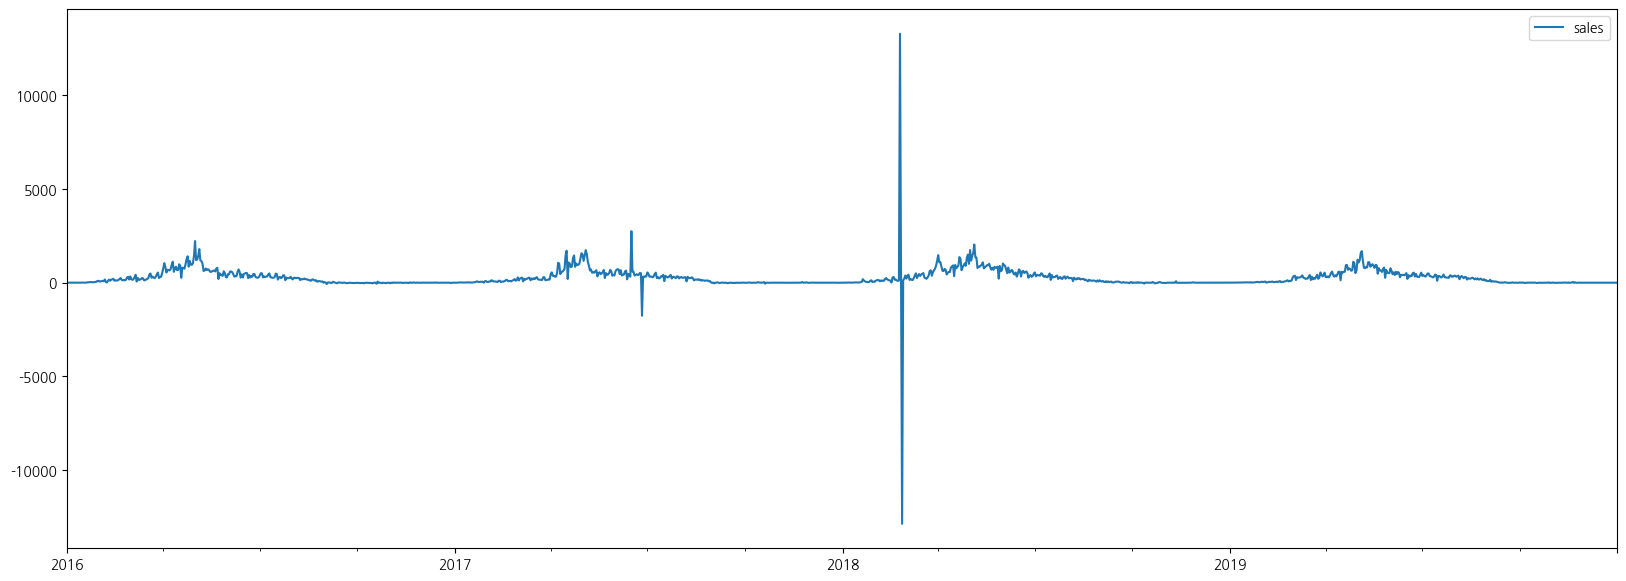

In [24]:
df.plot(figsize=(20, 7))
plt.show()

    이상치가 있음을 확인했다.
    그리고 마이너스가 찍힐 수는 있지만(환불로 인한), 2017년 중반부와 같은 마이너스는 말이 되지 않는다.
    중국 큰 손들(?)의 장난질일 수 있음 - 도메인 지식을 갖춘 이들과의 인터뷰가 이래서 중요하다.

In [25]:
# 시스템 오류로 인한 Outlier 삭제를 위해 값을 치환
df[(df['sales'] < -1000) | (df['sales'] > 2500)] = 0

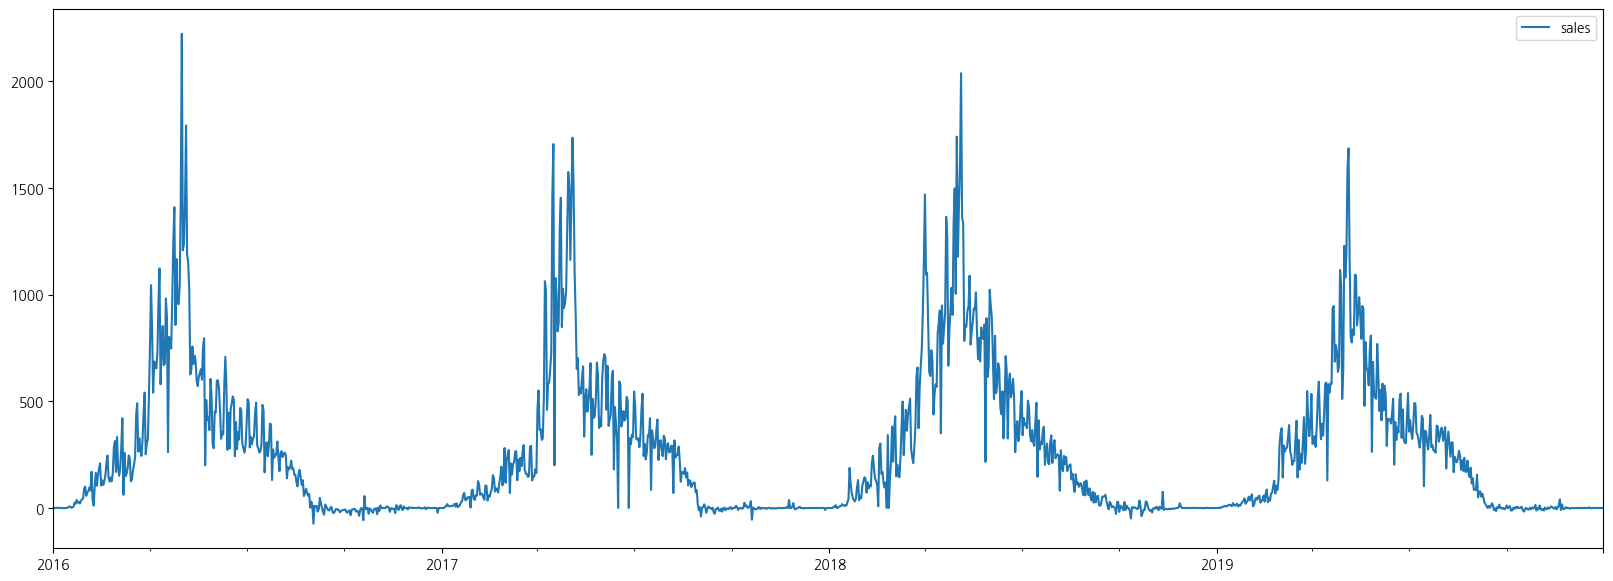

In [26]:
df.plot(figsize=(20, 7))
plt.show()

    특이점들의 대한 분석과 의문이 들어야 데이터를 해석할 수 있다.
    
    보통 확 증가하는 부분에서는 프로모션이 진행했음을 알 수 있고,
    보통 확 감소하는 부분에서 재고 비용이 많이 발생하게 된다.


In [27]:
# 학습 데이터는 2019년 여름 시즌 이전까지
train_df = df[:-200]

# test 데이터는 2019년 여름 시즌부터 겨울 시즌 전까지 Peak 100일에 대한 예측
test_df = df[-200:-100]

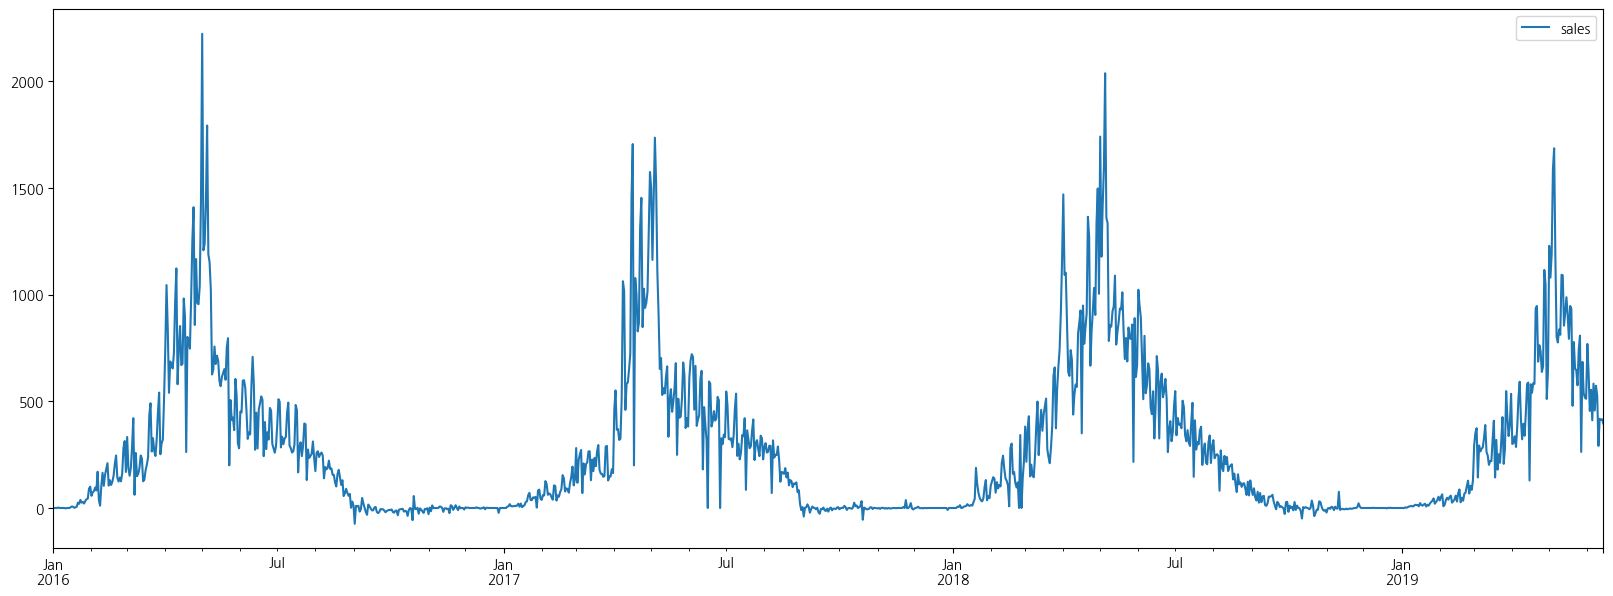

In [28]:
train_df.plot(figsize=(20, 7))
plt.show()

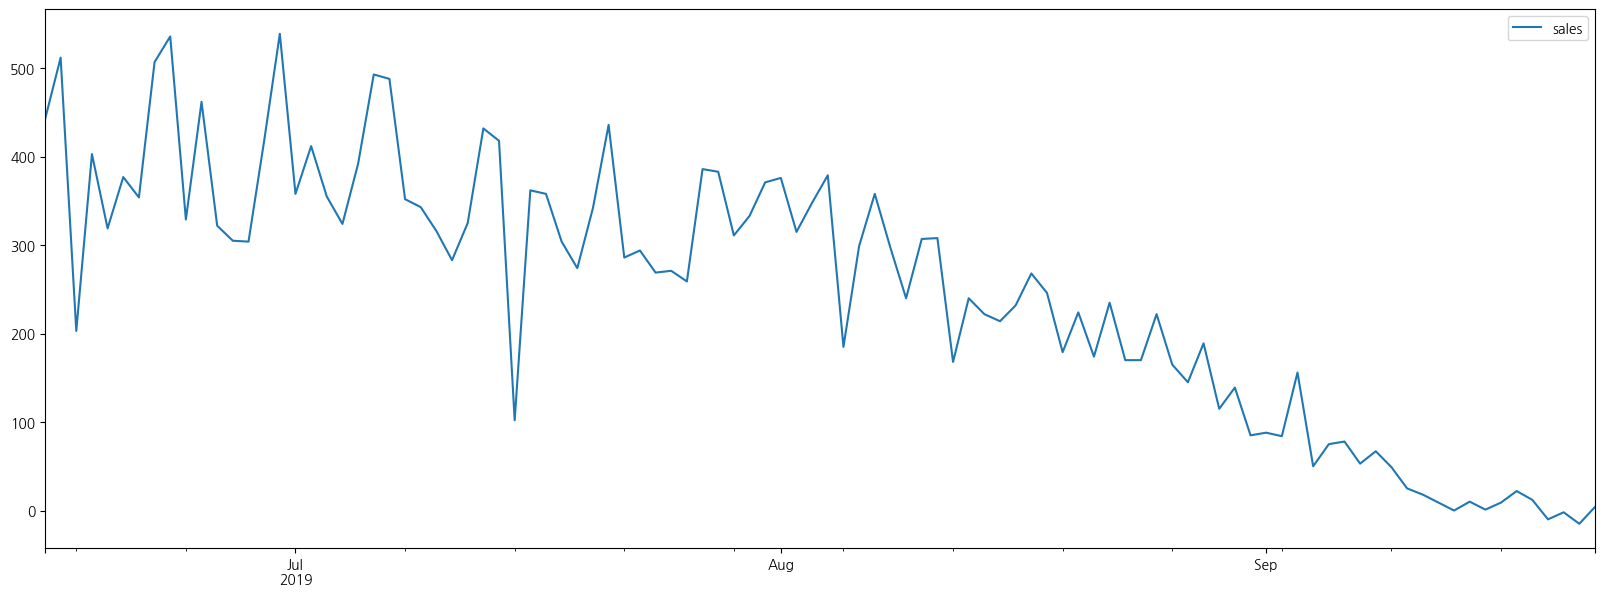

In [29]:
test_df.plot(figsize=(20, 7))
plt.show()

    판매량이 확 떨어지는 구간에 대해 예측을 해야 그 구간에서 더 이상 생산하지 않는다.
    그래서 6월의 판매량을 예측하게 되면, 그 8주 전인 4월의 발주량을 결정할 수 있게 된다.

# 6. 시계열 예측 모델링

## glounts를 이용한 방법 (호환 X)

In [ ]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from pathlib import Path

'''
ts_entry: 실제 데이터
forecast_entry: 예측 데이터
'''
def plot_prob_forecasts(ts_entry, forecast_entry):
    prediction_intervals = (90.0, 50.0)
    legend = ['sales', 'observations', 'median prediction'] + [f'{k}% prediction interval' for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(20, 7))

    ts_entry.plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which='both')
    plt.legend(legend, loc='upper left')
    plt.show()

# DeepAR 알고리즘을 사용하기 위해 df를 ListDataset으로 재생성
train_ds = ListDataset([{FieldName.TARGET: train_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2016-01-01 00:00:00", freq='D')
                        }],
                       freq='D')

test_ds = ListDataset([{FieldName.TARGET: test_df.values.flatten(),
                         FieldName.START: pd.Timestamp("2019-06-15 00:00:00", freq='D')
                        }],
                       freq='D')

# 시계열 예측 알고리즘 중 가장 많이 사용되고 있는 DeepAR(AutoRegression) 사용
estimator = DeepAREstimator(
    # 데이터 주기(D, W, M, Y)
    freq='D',
    # Trainer, cpu | gpu, 학습 반복 횟수
    trainer=Trainer(ctx='cpu', epochs=30, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=30,),
    # layer 수
    num_layers=4,
    # lstm 셀 개수
    num_cells=40,
    context_length=30,
    cell_type='lstm' # gru도 가능
    # 얼마 기간에 대해 예측할 것인가?
    prediction_length=30
)

predictor = estimator.train(train_ds)

## darts 기반 RNNModel을 이용한 방법

In [34]:
!pip install u8darts pytorch_lightning --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.9 MB/s eta 0:00:00


In [35]:
from darts import TimeSeries
from darts.models import RNNModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape, mae

In [36]:
series_train = TimeSeries.from_series(
    pd.Series(train_df.values.flatten(),
              index=pd.date_range("2016-01-01", periods=len(train_df), freq="D"),
              name="sales")
)

series_test = TimeSeries.from_series(
    pd.Series(test_df.values.flatten(),
              index=pd.date_range("2019-06-15", periods=len(test_df), freq="D"),
              name="sales")
)

In [37]:
# 스케일링
scaler = Scaler()

series_train_scaled = scaler.fit_transform(series_train)
series_test_scaled  = scaler.transform(series_test)

In [38]:
CONTEXT = 30
HORIZON = 30
TRAINING_LENGTH = 90  # input_chunk_length(=30) 보다 크거나 같아야 함(오류 방지)

# 모델 정의
model = RNNModel(
    model="LSTM",                   # 'LSTM' or 'GRU'
    input_chunk_length=CONTEXT,     # = context_length
    training_length=TRAINING_LENGTH,
    hidden_dim=40,                  # = num_cells
    n_rnn_layers=4,                 # = num_layers
    dropout=0.0,
    batch_size=32,
    n_epochs=30,                    # = epochs
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
    likelihood=GaussianLikelihood(),  # 확률적 예측 활성화 (샘플 기반)
    pl_trainer_kwargs={"accelerator": "cpu"},  # Colab GPU면 "gpu" 로
)

In [39]:
# 모델 학습
model.fit(series_train_scaled, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 46.2 K | train
6 | V               | Linear           | 82     | train
-------------------------------------------------------------
46.3 K    Trainable params
0         Non-trainable params
46.3 K    Total params
0.371     Total estimated model params size (MB)
7         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


RNNModel(model=LSTM, hidden_dim=40, n_rnn_layers=4, dropout=0.0, training_length=90, input_chunk_length=30, batch_size=32, n_epochs=30, optimizer_kwargs={'lr': 0.001}, random_state=42, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, beta_nll=0.0, prior_strength=1.0), pl_trainer_kwargs={'accelerator': 'cpu'})

In [40]:
# 예측: 30일; num_samples를 크게 주면(500~1000) 예측 구간(PI) 추정이 안정적
pred_scaled = model.predict(n=HORIZON, series=series_train_scaled, num_samples=500)

# 원래 스케일로 되돌리기
pred = scaler.inverse_transform(pred_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
# 평가 (가능하다면 test 구간 GT와 비교)
y_true = series_test[:HORIZON] if len(series_test) >= HORIZON else series_test
y_pred = pred if len(y_true) == len(pred) else pred[:len(y_true)]

print("MAE:", mae(y_true, y_pred))
print("MAPE:", mape(y_true, y_pred))

MAE: 81.69461099101201
MAPE: 20.742853571631247


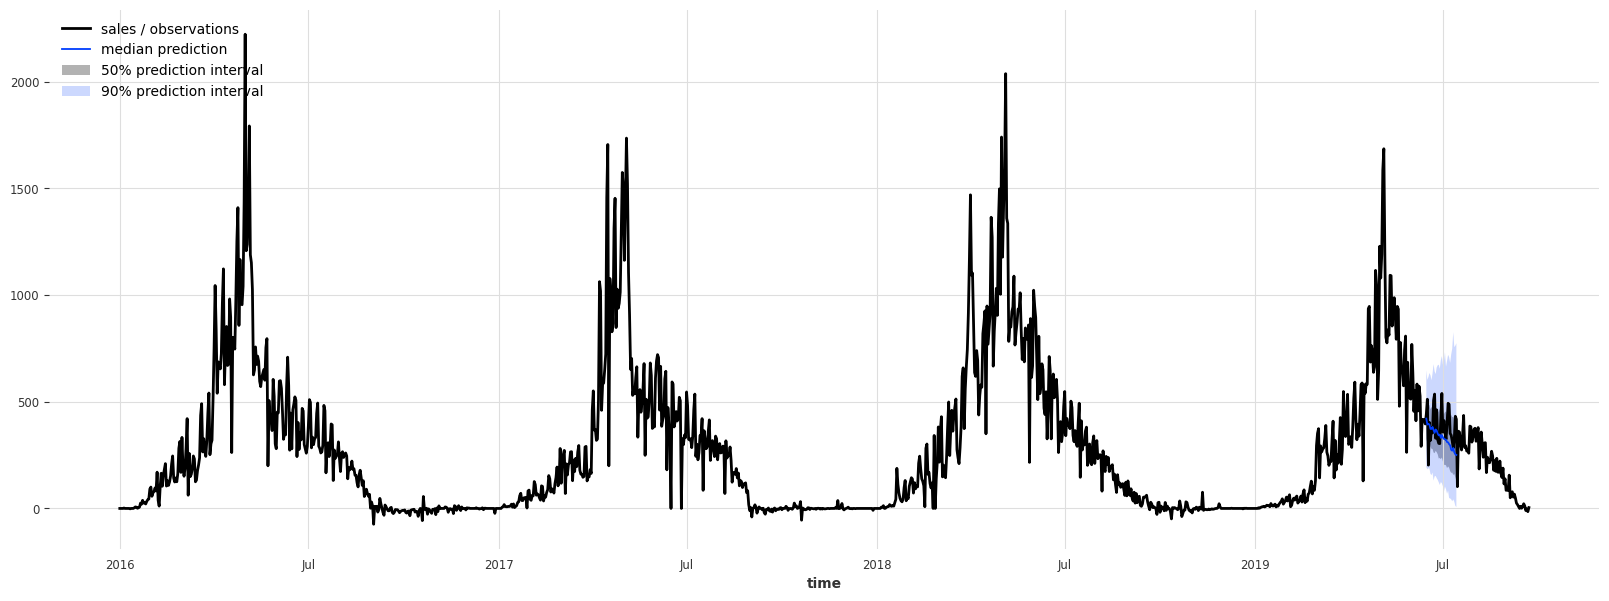

In [47]:
# 시각화
def plot_prob_forecasts(ts_entry, forecast_entry):
    plt.figure(figsize=(20, 7))

    # 1) 관측치
    ts_entry.plot(label="sales / observations")

    # 2) 예측이 확률적(샘플 여러 개)인 경우: 수동으로 분위수 계산
    has_all_values = hasattr(forecast_entry, "all_values")
    arr = forecast_entry.all_values(copy=False) if has_all_values else None

    if arr is not None and arr.ndim == 3 and arr.shape[2] > 1:
        # arr shape: (time, components, samples)  -> 단일 시계열이라 components=1 가정
        arr_ts = arr[:, 0, :]                 # (T, S)
        t = forecast_entry.time_index

        q05 = np.quantile(arr_ts, 0.05, axis=1)
        q25 = np.quantile(arr_ts, 0.25, axis=1)
        q50 = np.quantile(arr_ts, 0.50, axis=1)
        q75 = np.quantile(arr_ts, 0.75, axis=1)
        q95 = np.quantile(arr_ts, 0.95, axis=1)

        # 중앙값 라인
        plt.plot(t, q50, label="median prediction")

        # 예측구간 음영
        plt.fill_between(t, q25, q75, alpha=0.3, label="50% prediction interval")
        plt.fill_between(t, q05, q95, alpha=0.2, label="90% prediction interval")

    else:
        # 3) 결정적 예측(샘플 1개)인 경우: 그냥 라인만
        forecast_entry.plot(label="prediction")

    plt.grid(True, which="both")
    plt.legend(loc="upper left")
    plt.show()

# 과거 + 예측 시각화 (관측은 train+test 잇거나 필요 구간만)
full_series = series_train.concatenate(series_test)
plot_prob_forecasts(full_series, pred)